In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math as math
import csv
import csv
import re
from datetime import datetime
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import RegexpTokenizer
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from collections import Counter
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /home/zandred/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/zandred/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/zandred/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
#df = pd.read_csv('/home/zandred/environments/classified_data_for_model_without_preproc.csv')
df = pd.read_csv('/home/zandred/environments/df_final_model.csv')

In [5]:
df['class'] = df['class'].replace({0: 'legit', 1: 'suspicious'})

In [6]:
df

,as-set,processed_as_set,descr,members,mnt_by,AS_count,cone,days_since_modified,class,relationship,keyword_present,AS_Count_size,Cone_size,only_asn
0,as-set-link,"['set', 'link']",[],"['as-konnektikaru', 'as211366', 'as61230']",['link'],3,5,553,legit,0.600000,0,1,1,0
1,as-mobitex,['mobitex'],"['as', 'number', 'announced', 'mobitex']",['as57897'],['dcenter'],1,1,2381,suspicious,1.000000,0,0,1,1
2,as-active-fibre,"['active', 'fibre']","['as', 'announcement', 'af']",['as328068'],['as328068'],1,1,268,legit,1.000000,0,0,1,1
3,as-swcmcustomers,['swcmcustomers'],"['legacy', 'object', 'please', 'use', 'as3303'...","['as3303', 'as-swcmcustomers']","['ch', 'unisource']",2,1,116,suspicious,2.000000,1,1,1,0
4,as-60139,['60139'],"['customer', 'sever', 'telecom', 'global', 'ac...","['as60139', 'as50736', 'as197780', 'as48180']","['sever', 'telecom']",4,4,1503,legit,1.000000,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2365,as394127:as-all,"['as394127', 'all']","['360', 'e', '10th', 'ave']",['as394127'],"['ars', '108']",1,1,1082,legit,1.000000,0,0,1,1
2366,as-avmcau,['avmcau'],"['as', 'avmcau']",['as132430'],"['avmc', 'au']",1,1,196,legit,1.000000,0,0,1,1
2367,as11996:as-cust1,"['as11996', 'cust1']","['po', 'box', '1761']","['as33201', 'as-all', 'as10381', 'as-swcp', 'a...","['lisl', '2']",9,7,698,suspicious,1.285714,0,1,1,0
2368,as264646:as-tierranet,"['as264646', 'tierranet']","['dobleclick', 'software', 'e', 'ingeneria']",['as269746'],"['co', 'dsin']",1,1,27,legit,1.000000,0,0,1,1


In [140]:
df.loc[:, 'as-set'] = df['as-set'].str.lower()
df.loc[:, 'descr'] = df['descr'].str.lower()
df.loc[:, 'members'] = df['members'].str.lower()
df.loc[:, 'mnt-by'] = df['mnt-by'].str.lower()

In [141]:
df = df.copy()

# Convert 'last-modified' column to datetime 
df['last-modified'] = pd.to_datetime(df['last-modified'], format='%d-%m-%Y', errors='coerce')

# For dates not parsed yet, try to parse them with the second format
unparsed_dates = df['last-modified'].isna()
df.loc[unparsed_dates, 'last-modified'] = pd.to_datetime(df[unparsed_dates]['last-modified'], format='%d/%m/%Y', errors='coerce')

# Calculate 'days_since_modified' column
current_date = pd.to_datetime('today').normalize()
df.loc[:, 'days_since_modified'] = (current_date - df['last-modified']).dt.days

# Drop 'last-modified' column
df.drop(columns=['last-modified'], inplace=True)


In [142]:
# Drop rows with non-finite values
df = df.dropna(subset=['days_since_modified']).reset_index(drop=True)

# Convert the column to integers
df['days_since_modified'] = df['days_since_modified'].fillna(0).astype(int)

In [143]:
def process_as_set(as_set):
    # Check if the input is a string
    if not isinstance(as_set, str) or as_set.strip() == '':
        return []

    # Remove initial 'as-' from the as-set
    as_set = as_set.replace('as-', '', 1)
    
    # Tokenize the as-set
    tokenizer = RegexpTokenizer(r'\b\w+\b')
    tokens = tokenizer.tokenize(as_set.replace('-', ' '))
    
    return tokens

def process_members(members):
    # Check if the input is a string
    if not isinstance(members, str) or members.strip() == '':
        return []

    # Split the string on commas
    tokens = members.split(',')

    # Remove leading and trailing whitespace from each token
    tokens = [token.strip() for token in tokens]
    
    return tokens

def process_text(text):
    # Check if the input is a string
    if not isinstance(text, str) or text.strip() == '':
        return []

    # Tokenize the text
    tokenizer = RegexpTokenizer(r'\b\w[\w-]*\b')
    tokens = tokenizer.tokenize(text)
    
    # Lowercase all words
    words = [word.lower() for word in tokens]

    # Handle specific cases
    words = ['as' if word in ['as', 'ases', 'ass'] else word for word in words]
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    stop_words.remove('as')  # Remove 'as' from the set of stop words
    words = [word for word in words if word not in stop_words]
    
    # Perform lemmatization
    wordnet = WordNetLemmatizer()
    words = [wordnet.lemmatize(word) if word != 'as' else 'as' for word in words]
    
    return words

# Apply the function to the 'members' column
df['processed_members'] = df['members'].apply(process_members)


# Apply the function to the 'as-set' column
df['processed_as_set'] = df['as-set'].apply(process_as_set)

# Apply the function to the 'descr' column
df['processed_descr'] = df['descr'].apply(process_text)

In [144]:
new_order=['as-set', 'processed_as_set','processed_descr', 'processed_members','processed_mnt_by','AS_count', 'cone', 'days_since_modified','class']
df = df.reindex(columns=new_order)
df = df.rename(columns={'processed_descr': 'descr'})
df = df.rename(columns={'processed_members': 'members'})

In [145]:
df

,as-set,processed_as_set,descr,members,mnt_by,AS_count,cone,days_since_modified,class
0,as-dtageuro,[dtageuro],"[as, supported, europe, deutsche, telekom]",[as-dtag],"[dtag, rr]",1,1,928,0
1,as-claranetfr,[claranetfr],"[claranet, france, customer]","[as8975, as15489]",[as8975],2,2,1975,0
2,as-btteltocip,[btteltocip],"[evolutio, customer, peer, announced, as6669]","[as-bttel, as-btespanix]",[evolutio],2,125,872,0
3,as-datanet,[datanet],"[datanet, as]","[as5588, as3340, as6790, as6784, as2012, as822...","[datanet, bt]",109,3555,182,0
4,as-janeteuro,[janeteuro],"[janet, transit, customer, as, advertised, eur...","[as786, as7, as2818, as4373, as5459, as5503, a...","[jips, nosc]",56,64,319,0
...,...,...,...,...,...,...,...,...,...
2363,as-328977,[328977],[wavex],"[as-328977, as-328977, as37100, as328987, as32...",[wisp2],8,16,118,0
2364,as-cmvas,[cmvas],"[cmvas, as-set]","[as37650, as328218]",[cmv],2,2,285,0
2365,as-csuc,[csuc],[csuc],[as328752],[csuc2],1,1,211,0
2366,as-329174,[329174],"[as-set, swift, broadband, limited, asn, 329174]","[as329174, as328977]","[swift, broadband]",2,2,117,0


In [146]:
# Create the 'only_asn' attribute
df['only_asn'] = 0
#converting members to string type
df['members'] = df['members'].astype(str)

# Iterate over each row in the DataFrame
for index, row in df.iterrows():
    members = row['members']
    tokens = re.findall(r'\b\w+\b', members)  # Split the string into tokens
    
    is_only_asn = all(re.match(r'^as\d+', token.lower()) for token in tokens)
    
    # Set the 'only_asn' attribute based on the members
    if is_only_asn:
        df.at[index, 'only_asn'] = 1

In [147]:
df['relationship'] = df['AS_count'] / df['cone'].replace(0, 0.0001)

In [148]:
# List of keywords for each attribute
descr_keywords = ['route', 'servers', 'isp', 'exchange', 'cix', 'ix', 'nix', 'upstreams', 'vodafone']
processed_as_set_keywords = ['rs', 'ix', 'decix', 'jaguar', 'amsix', 'lyonix', 'nix', 'cix', 'nixcz', 'upstreams', 'swissix', 'tele2', 'sfinx', 'uaeix']
mnt_by_keywords = ['decix', 'lir', 'jaguar']

# Initialize the 'keyword_present' field as 0 for all rows
df['keyword_present'] = 0

# Iterate over each row in the DataFrame
for index, row in df.iterrows():
    # Check if any keyword is present in the 'descr' attribute
    for keyword in descr_keywords:
        if keyword in row['descr']:
            df.at[index, 'keyword_present'] = 1
            break  # Stop checking once a keyword is found

    # Check if any keyword is present in the 'processed_as_set' attribute
    for keyword in processed_as_set_keywords:
        if keyword in row['processed_as_set']:
            df.at[index, 'keyword_present'] = 1
            break  # Stop checking once a keyword is found

    # Check if any keyword is present in the 'mnt_by' attribute
    for keyword in mnt_by_keywords:
        if keyword in row['mnt_by']:
            df.at[index, 'keyword_present'] = 1
            break  # Stop checking once a keyword is found


In [149]:
df

,as-set,processed_as_set,descr,members,mnt_by,AS_count,cone,days_since_modified,class,only_asn,relationship,keyword_present
0,as-dtageuro,[dtageuro],"[as, supported, europe, deutsche, telekom]",['as-dtag'],"[dtag, rr]",1,1,928,0,0,1.000000,0
1,as-claranetfr,[claranetfr],"[claranet, france, customer]","['as8975', 'as15489']",[as8975],2,2,1975,0,1,1.000000,0
2,as-btteltocip,[btteltocip],"[evolutio, customer, peer, announced, as6669]","['as-bttel', 'as-btespanix']",[evolutio],2,125,872,0,0,0.016000,0
3,as-datanet,[datanet],"[datanet, as]","['as5588', 'as3340', 'as6790', 'as6784', 'as20...","[datanet, bt]",109,3555,182,0,0,0.030661,0
4,as-janeteuro,[janeteuro],"[janet, transit, customer, as, advertised, eur...","['as786', 'as7', 'as2818', 'as4373', 'as5459',...","[jips, nosc]",56,64,319,0,0,0.875000,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2363,as-328977,[328977],[wavex],"['as-328977', 'as-328977', 'as37100', 'as32898...",[wisp2],8,16,118,0,0,0.500000,0
2364,as-cmvas,[cmvas],"[cmvas, as-set]","['as37650', 'as328218']",[cmv],2,2,285,0,1,1.000000,0
2365,as-csuc,[csuc],[csuc],['as328752'],[csuc2],1,1,211,0,1,1.000000,0
2366,as-329174,[329174],"[as-set, swift, broadband, limited, asn, 329174]","['as329174', 'as328977']","[swift, broadband]",2,2,117,0,1,1.000000,0


In [161]:
count = len(df[df['class'] == 'suspicious'])
print("The number of suspiciou instances is {}".format(count))

The number of suspiciou instances is 578


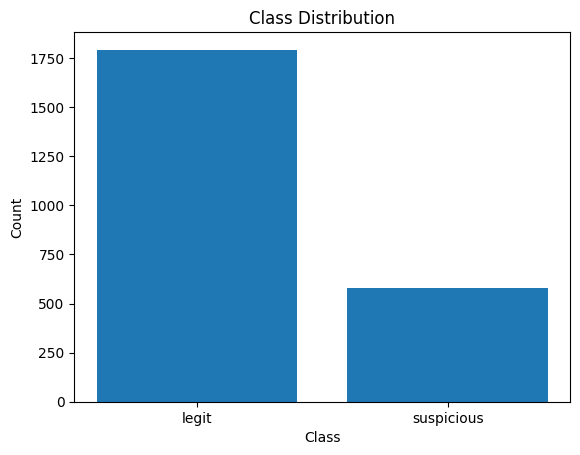

In [7]:
# Count the occurrences of each class
class_counts = df['class'].value_counts()

# Create a bar plot
plt.bar(class_counts.index, class_counts.values)

# Add labels and title
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')

# Display the plot
plt.show()

In [8]:
print('Legit cases make', round(df['class'].value_counts()[0]/len(df) * 100,2), '% of the sample')
print('Suspicious', round(df['class'].value_counts()[1]/len(df) * 100,2), '% of the sample')

Legit cases make 75.61 % of the sample
Suspicious 24.39 % of the sample


In [164]:
# Mapping dictionary
class_mapping = {'legit': 0, 'suspicious': 1}

# Convert 'class' column using mapping dictionary
df['class'] = df['class'].map(class_mapping)

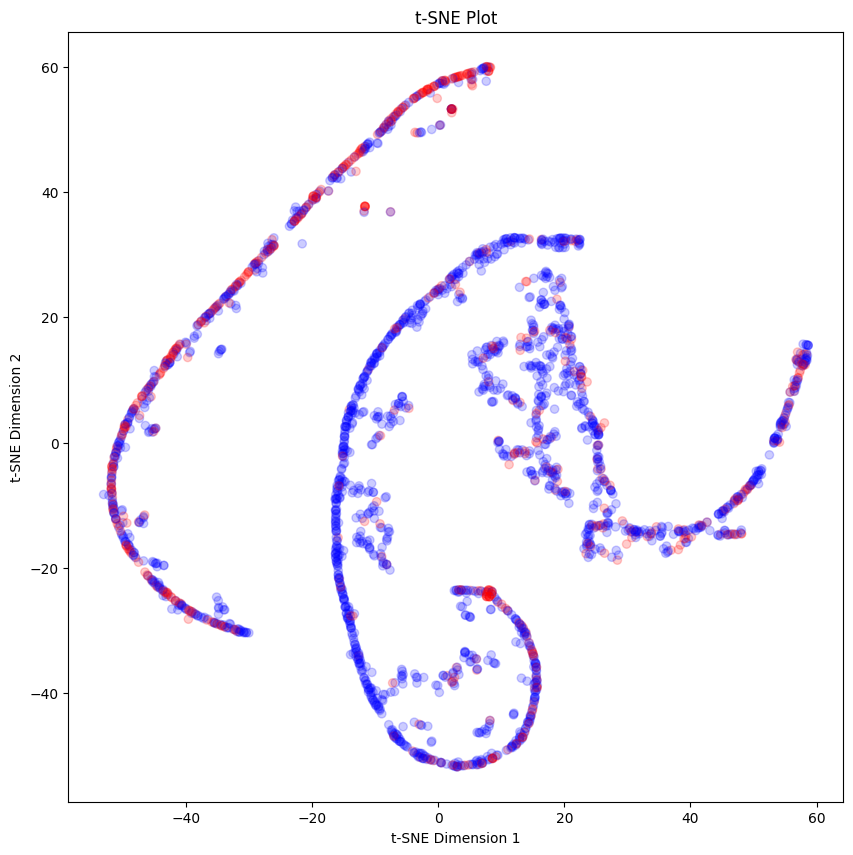

In [166]:
# Select numerical columns
df_numeric = df[['days_since_modified', 'relationship', 'only_asn', 'cone', 'AS_count', 'keyword_present']]

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=0)
tsne_obj = tsne.fit_transform(df_numeric)

# Prepare the results for plotting
tsne_df = pd.DataFrame({'X': tsne_obj[:, 0], 'Y': tsne_obj[:, 1], 'class': df['class'].values})

# Define the color map
colormap = {0: 'blue', 1: 'red'}

# Plot the results
plt.figure(figsize=(10, 10))
plt.scatter(tsne_df['X'], tsne_df['Y'], c=tsne_df['class'].map(colormap), alpha=0.2)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Plot')
plt.show()


In [168]:
columns_to_drop = ['processed_as_set', 'descr', 'members', 'mnt_by']
df = df.drop(columns_to_drop, axis=1)

In [171]:
df

,as-set,AS_count,cone,days_since_modified,relationship,only_asn,keyword_present,class
0,as-dtageuro,1,1,928,1.000000,0,0,0
1,as-claranetfr,2,2,1975,1.000000,1,0,0
2,as-btteltocip,2,125,872,0.016000,0,0,0
3,as-datanet,109,3555,182,0.030661,0,0,0
4,as-janeteuro,56,64,319,0.875000,0,0,0
...,...,...,...,...,...,...,...,...
2363,as-328977,8,16,118,0.500000,0,0,0
2364,as-cmvas,2,2,285,1.000000,1,0,0
2365,as-csuc,1,1,211,1.000000,1,0,0
2366,as-329174,2,2,117,1.000000,1,0,0


In [170]:
new_order=['as-set', 'AS_count', 'cone', 'days_since_modified', 'relationship', 'only_asn', 'keyword_present', 'class']
df = df.reindex(columns=new_order)

In [32]:
df.to_csv('reviewagian.csv', index=False)